In [82]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random

res_dir = '/home/k1455023/Documents/Utopia/UtopiaSimulation/param_tests'

In [14]:
def getCSV(VIC,N,NF,IC):
    # for a given virus-infection-chance, number-of-people, ave-no-friends
    # and immunity chance, return numpy array where cols are 
    # [# infected, # susceptible] and rows are time steps
    suffix = 'VIC'+str(VIC)+'_N'+str(N)+'_K'+str(NF)+'_IC'+str(IC)+'.csv'
    dat = []
    with open(res_dir+'/'+suffix, 'r') as f:
        for line in f:
            ld = line.split(' ')
            dat.append([float(ld[1]), float(ld[3].rstrip())])
    return np.array(dat)

In [15]:
def getParamsFromFname(name):
    s_name = name.split('_')
    VIC = float(s_name[0].lstrip('VIC'))
    N = int(s_name[1].lstrip('N'))
    NF= int(s_name[2].lstrip('K'))
    IC= float(s_name[3].lstrip('IC').rstrip('.csv'))

    return VIC, N, NF, IC

In [16]:
def getParamsTestedFromFiles():
    # return dataframe based on parameters explored in files
    fs = os.listdir(res_dir)
    df = pd.DataFrame(columns=['VIC','N','K','IC'])
    for i, fname in enumerate(fs):
        dat= getParamsFromFname(fname)
        df.loc[i]=dat   
    return df

In [38]:
t_df=getParamsTestedFromFiles()

In [37]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def getClosestTestedParams(tested_df,VIC, N, K, IC):
    VICs = tested_df.VIC.unique()
    Ns = tested_df.N.unique()
    Ks = tested_df.K.unique()
    ICs = tested_df.IC.unique()
    
    return (find_nearest(VICs,VIC), find_nearest(Ns,N),find_nearest(Ks,K),
            find_nearest(ICs,IC))

getClosestTestedParams(t_df,6.6, 135, 35, 5)

(7.0, 135.0, 36.0, 0.0)

In [78]:
def find_indices_conditional(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

In [125]:
def getHypotheticalWithSpikes(t0,VIC,N,K,IC):
    vals = getCSV(VIC,N,K,IC)[t0:,1] # get true infected percentage
    # get list of indices with values below 90% initial population
    i_below_10_pc = find_indices_conditional(vals, lambda e: e<90)
    no_small_vals = len(i_below_10_pc)
    # select points to mimic clicks,  try for 10 clicks per run
    if no_small_vals < 10:
        clicks = i_below_10_pc
    else:
        clicks = np.random.choice(i_below_10_pc, size=10, replace=False)
    
    for c in clicks:
        vals[c] = vals[c] + 10
    # return the new array, and the times at which the clicks are simulated
    return vals, clicks

In [105]:
def getGradient(data,delta):
    res = np.abs(data[delta:] - data[:(data.shape[0]-delta)])
    return res

In [106]:
def getEquilibrium(delta,thresh,data):
    grad = getGradient(data,delta)
    return np.less(grad,np.zeros(grad.shape[0])+thresh)       

array([False,  True,  True, ...,  True, False,  True], dtype=bool)

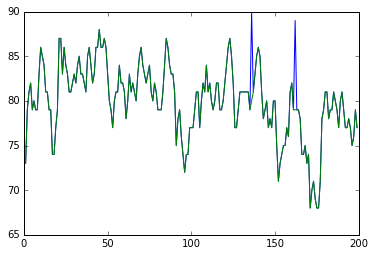

In [101]:

%matplotlib inline
plt.plot(getHypotheticalWithSpikes(4,100,6,0)[1000:1200])
plt.plot(getCSV(4,100,6,0)[1000:1200,1])

In [177]:
def calcEquilibriumPenalty(params,t0,delta,thresh):
    VIC = int(params[0])
    N=int(params[1])
    K=int(params[2])
    IC=int(params[3])
    true_data = getCSV(VIC,N,K,IC)[t0:,1]
    eq = getEquilibrium(delta,thresh,true_data)
    return 1 - np.sum(eq)/float(eq.shape[0])

In [204]:
def calcNonEqPenalty(params,t0,delta,thresh):
    VIC = int(params[0])
    N= int(params[1])
    K= int(params[2])
    IC=int(params[3])
    dat, clicks = getHypotheticalWithSpikes(t0,VIC,N,K,IC)
    eq = getEquilibrium(delta,thresh,dat)
    # for each click, incur penalty if no non-equilibrium registered
    penalty_count=0
    if len(clicks) > 0:
        for c in clicks:
            eq_section = np.invert(eq[c:c+delta]) # now count of non-equilibrium steps
            if np.sum(eq_section)<1:
                penalty_count = penalty_count + 1
        return penalty_count/float(len(clicks))  
    else:
        return 0.0    

In [178]:
calcEquilibriumPenalty([6,65,31,0],200,5,12)

0.011699164345403856

In [173]:
calcNonEqPenalty([6,65,31,0],200,5,5)

0.1

In [220]:
def writeResultsDFToFile(delta,thresh):
    direc=res_dir.rstrip('param_tests')+'optim'
    fnm='D'+str(delta)+'_T'+str(thresh)+'.csv'
    
    t_df=getParamsTestedFromFiles()
    eq_pen = pd.DataFrame(t_df.apply(calcEquilibriumPenalty,axis=1,
                                     args=(200,delta,thresh)),columns=['EqPen'])
    neq_pen= pd.DataFrame(t_df.apply(calcNonEqPenalty,axis=1,
                                     args=(200,delta,thresh)),columns=['NeqPen'])
    
    t_df=t_df.merge(eq_pen,right_index=True, left_index=True)
    t_df=t_df.merge(neq_pen,right_index=True, left_index=True)
    
    t_df.to_csv(direc+'/'+fnm)
    
   

In [ ]:
windows = np.arange(2,31)
thresholds = np.arange(2,31)
for delta in windows:
    for thresh in thresholds:
        writeResultsDFToFile(delta,thresh)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30]


In [224]:
def readResultsDF(delta,thresh):
    direc=res_dir.rstrip('param_tests')+'optim'
    fnm='D'+str(delta)+'_T'+str(thresh)+'.csv'
    
    return pd.read_csv(direc+'/'+fnm)
readResultsDF(2,10)

,Unnamed: 0,VIC,N,K,IC,EqPen,NeqPen
0,0,10,110,11,0,0.027253,0.5
1,1,2,15,6,0,0.099555,0.1
2,2,4,130,21,0,0.002781,1.0
3,3,0,70,11,0,0.000000,0.0
4,4,0,145,36,0,0.000000,0.0
5,5,3,70,31,0,0.009455,0.9
6,6,3,55,16,0,0.013904,0.6
7,7,2,110,31,0,0.000000,1.0
8,8,10,130,36,0,0.010567,0.9
9,9,9,130,6,0,0.012792,0.3
